<a href="https://colab.research.google.com/github/KFurudate/Midoribon/blob/main/chap6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6章 GLMの応用範囲をひろげる -ロジスティック回帰など-


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [3]:
data_dir = "/content/drive/My Drive/Midoribon/input/"
data =  pd.read_csv(os.path.join(data_dir, 'chap6a_data.csv'))

In [4]:
print(len(data))
data.head()

100


,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [5]:
data.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [6]:
print(data.f)

0     C
1     C
2     C
3     C
4     C
     ..
95    T
96    T
97    T
98    T
99    T
Name: f, Length: 100, dtype: object


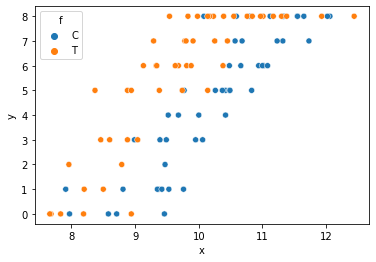

In [7]:
sns.scatterplot(x='x', y='y', hue='f', data=data)
plt.show()

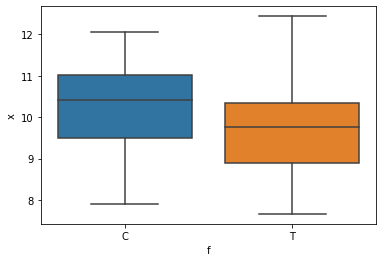

In [9]:
sns.boxplot(x='f', y='x', data=data)
plt.show()

### 二項分布で表現する「あり・なし」カウントデータ

二項分布とは、結果が2値であるベルヌーイの施行を独立にn回行った（上限がある）ときの確率変数をあらわす離散確率分布。


*Pr(y | N, q)* はN個の観察データ中、y個で事象が起こる確率


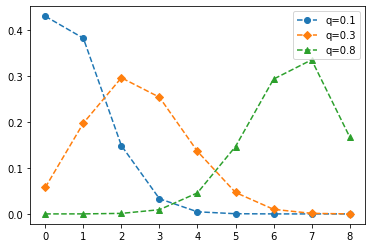

In [37]:
y = np.arange(0, 9)
plt.plot(pd.Series(stats.binom.pmf(y, 8, 0.1), index=y), 'o--', label='q=0.1')
plt.plot(pd.Series(stats.binom.pmf(y, 8, 0.3), index=y), 'D--', label='q=0.3')
plt.plot(pd.Series(stats.binom.pmf(y, 8, 0.8), index=y), '^--', label='q=0.8')
plt.legend()
plt.show()

### ロジスティック回帰とロジットリンク関数

GLMは、確率分布・リンク関数・線形予測子を指定し、足し算の数式であらわされるモデル（線形モデル）。
ロジスティック回帰は、二項分布(確率分布)、ロジットリンク関数(リンク関数)を用いる。

$$
q_i = logistic (z_i) = \frac{1} {1+\exp(-z_i)}
$$

ziは、線形予測子で、 $z_i = \beta_1 + \beta_2 x_i + ...$

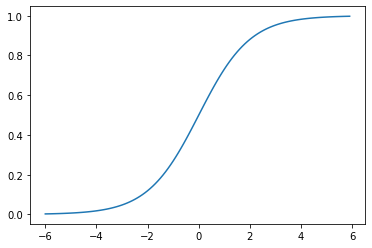

In [25]:
def sigmoid(zi):
    return 1 /(1+np.exp(-zi))

zi = np.arange(-6, 6, 0.1)
qi = sigmoid(zi)

plt.plot(zi, qi)
ｐｌｔ.show()

ロジット関数は、ロジスティック関数の逆関数である。

$$
logit(q_i)=\log \frac {q_i}{1-q_i}
$$

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm('y + I(N-y)~ x + f', data=data, family=sm.families.Binomial())

In [29]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sun, 04 Oct 2020   Deviance:                       123.03
Time:                        00:29:35   Pearson chi2:                     109.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

In [30]:
β1 = -19.5361
β2 = 1.9524
β3 = 2.0215

In [ ]:
x = np.linspace(7, 12, 100)
z_c = x*β2 + β1
z_t = x*β2 + β1 + β3
y_c = sigmoid(z_c)*8
y_t = sigmoid(z_t)*8

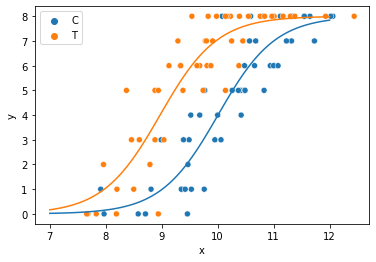

In [58]:
plt.plot(x, y_c)
plt.plot(x, y_t)

sns.scatterplot(x='x', y='y', hue='f', data=data)

plt.legend()
plt.show()

In [52]:
df_c = pd.DataFrame()
df_t = pd.DataFrame()
df_c["x"] = np.linspace(7,12,100)
df_t["x"] = np.linspace(7,12,100)
df_c["f"] = "C"
df_t["f"] = "T"
predict_c = result.predict(df_c)*8
predict_t = result.predict(df_t)*8

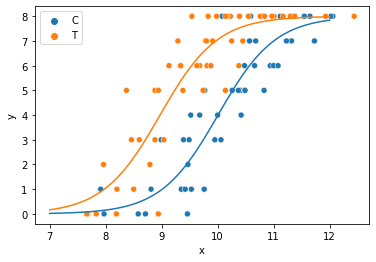

In [55]:
plt.plot(df_c.x, predict_c)
plt.plot(df_t.x, predict_t)

sns.scatterplot(x='x', y='y', hue='f', data=data)

plt.legend()
plt.show()

### ロジスティック回帰のモデル選択

In [170]:
def stepAIC(data, descriptors):
    best_aic = float("inf")
    for desk in descriptors:
      formula = 'y + I(N-y) ~ ' + ' + '.join(desk)
      model = smf.glm(formula=formula, 
                      data=data, 
                      family=sm.families.Binomial()).fit()

      print(f"model: {formula},  AIC: {model.aic}")
      print("*************************************")

      if best_aic > model.aic:
        best_aic, best_model = model.aic, model
    return best_model

In [172]:
descriptors = ["1", "f", "x", "xf"]
best_model = stepAIC(data, descriptors)

print(best_model.summary2())

model: y + I(N-y) ~ 1,  AIC: 644.4093416623778
*************************************
model: y + I(N-y) ~ f,  AIC: 637.7597534566678
*************************************
model: y + I(N-y) ~ x,  AIC: 364.345443283716
*************************************
model: y + I(N-y) ~ x + f,  AIC: 272.2111292852233
*************************************
               Results: Generalized linear model
Model:              GLM               AIC:            272.2111 
Link Function:      logit             BIC:            -323.6676
Dependent Variable: ['y', 'I(N - y)'] Log-Likelihood: -133.11  
Date:               2020-10-04 02:53  LL-Null:        -321.20  
No. Observations:   100               Deviance:       123.03   
Df Model:           2                 Pearson chi2:   109.     
Df Residuals:       97                Scale:          1.0000   
Method:             IRLS                                       
---------------------------------------------------------------
             Coef.   Std.Err.   

### 交互作用項の入った線形予測子

線形予測子$\beta_1 + \beta_2 x_i + \beta_3 f_i$をさらに複雑化して、交互作用(interaction)項を追加
$$logit(q_i) = \beta_1 + \beta_2 x_i + \beta_3 f_i + \beta_4 x_i f_i$$

In [173]:
# AICは悪くないが、モデルが複雑になるため、むやみに交互作用項を入れない
model = smf.glm('y + I(N-y)~ x*f',data=data, family=sm.families.Binomial())
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM               AIC:            273.6106 
Link Function:      logit             BIC:            -319.6630
Dependent Variable: ['y', 'I(N - y)'] Log-Likelihood: -132.81  
Date:               2020-10-04 02:55  LL-Null:        -321.20  
No. Observations:   100               Deviance:       122.43   
Df Model:           3                 Pearson chi2:   109.     
Df Residuals:       96                Scale:          1.0000   
Method:             IRLS                                       
---------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------
Intercept    -18.5233   1.8861 -9.8209 0.0000 -22.2200 -14.8266
f[T.T]        -0.0638   2.7036 -0.0236 0.9812  -5.3628   5.2352
x              1.8525   0.1856  9.9826 0.0000   1.4888   2.2162
x:f[T.T]       0.2163   0.2801  0.7724 0.4399  -0.3326   0.7653
===============================================================

"""

### 割算値いらずのオフセット項つき回帰

観測データどうしの割算値は、観測データの情報や分布が失われる危険性がある。


In [174]:
data2 =  pd.read_csv(os.path.join(data_dir, 'chap6b_data.csv'))

In [176]:
data2

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0
...,...,...,...
95,57,0.76,9.8
96,49,0.17,12.5
97,95,0.98,11.4
98,27,0.54,5.4


In [178]:
data2.describe()

,y,x,A
count,100.000000,100.000000,100.000000
mean,48.090000,0.514100,10.468000
std,17.137056,0.188573,2.927262
min,13.000000,0.050000,3.500000
25%,36.000000,0.400000,8.800000
50%,46.000000,0.515000,10.300000
75%,59.500000,0.642500,12.150000
max,95.000000,0.990000,17.400000


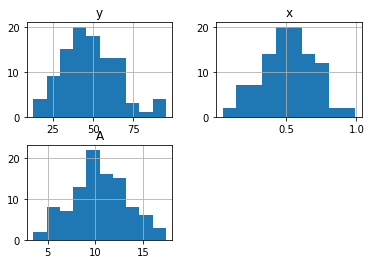

In [180]:
data2.hist()
plt.show()

In [181]:
model = smf.glm('y~x', offset=np.log(data2.A), data=data2, family=sm.families.Poisson())

In [182]:
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            650.3406 
Link Function:      log              BIC:            -369.6983
Dependent Variable: y                Log-Likelihood: -323.17  
Date:               2020-10-04 03:05 LL-Null:        -585.38  
No. Observations:   100              Deviance:       81.608   
Df Model:           1                Pearson chi2:   81.5     
Df Residuals:       98               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     0.9731    0.0451  21.5999  0.0000  0.8848  1.0614
x             1.0383    0.0777  13.3638  0.0000  0.8860  1.1905
==============================================================

"""

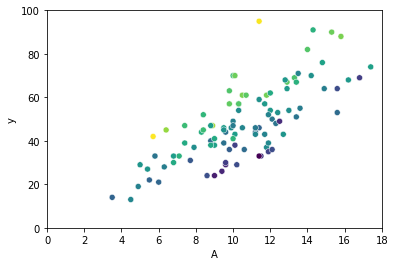

In [192]:
sns.scatterplot(x='A', y='y', c=data2.x, data=data2)
plt.xlim(0,18)
plt.ylim(0,100)
plt.show()

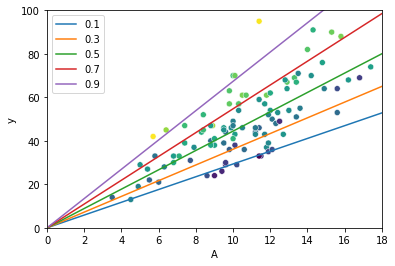

In [203]:
df_predict = pd.DataFrame()
df_predict["x"] = 0
df_predict["A"] = np.arange(0.1, 20, 0.1)
for x in (0.1, 0.3, 0.5, 0.7, 0.9):
    df_predict["x"] = x
    plt.plot(df_predict.A, result.predict(df_predict, offset=np.log(df_predict.A)), label=x)

sns.scatterplot(x='A', y='y', c=data2.x, data=data2)
plt.xlim(0,18)
plt.ylim(0,100)
plt.xlabel("A")
plt.ylabel("y")
plt.legend()
plt.show()

### 正規分布とその尤度

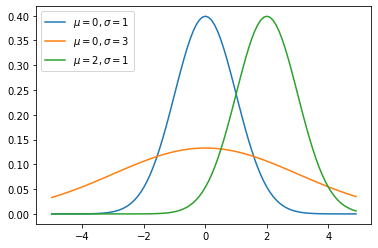

In [205]:
y = np.arange(-5,5,0.1)
plt.plot(pd.Series(stats.norm.pdf(y, loc=0, scale=1), index=y), label=r'$\mu=0, \sigma=1$')
plt.plot(pd.Series(stats.norm.pdf(y, loc=0, scale=3), index=y), label=r'$\mu=0, \sigma=3$')
plt.plot(pd.Series(stats.norm.pdf(y, loc=2, scale=1), index=y), label=r'$\mu=2, \sigma=1$')
plt.legend()
plt.show()

### ガンマ分布のGLM

In [214]:
data3 =  pd.read_csv(os.path.join(data_dir, 'chap6c_data.csv'), index_col=0)

In [216]:
data3.head()

,x,y
1,0.001000,0.000887
2,0.017306,0.023465
3,0.033612,0.069876
4,0.049918,0.034340
5,0.066224,0.026520


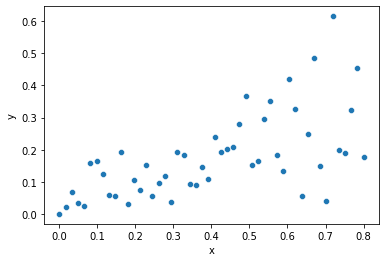

In [217]:
sns.scatterplot(x='x', y='y', data=data3)
plt.show()

In [218]:
model = smf.glm('y~np.log(x)', data=data3, family=sm.families.Gamma(link=sm.families.links.log))
result = model.fit()
result.summary2()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            -112.9416
Link Function:      log              BIC:            -170.5264
Dependent Variable: y                Log-Likelihood: 58.471   
Date:               2020-10-04 03:50 LL-Null:        30.606   
No. Observations:   50               Deviance:       17.251   
Df Model:           1                Pearson chi2:   15.6     
Df Residuals:       48               Scale:          0.32508  
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
Intercept  -1.0403    0.1188  -8.7592  0.0000  -1.2731  -0.8075
np.log(x)   0.6832    0.0684   9.9921  0.0000   0.5492   0.8173
==============================================================

"""

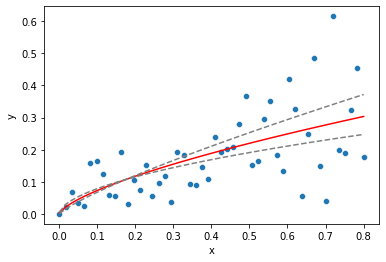

In [237]:
intercept = result.params["Intercept"]
nplog = result.params["np.log(x)"]
pred = np.exp(intercept + np.log(data.x) * nplog)
plt.plot(data.x, pred, c="r")

ci_upper=np.exp(-0.8075 + np.log(data.x)*0.8173)
ci_lower=np.exp(-1.2731 + np.log(data.x)*0.5492)
plt.plot(data.x, ci_upper, linestyle='--', color='gray', marker='') 
plt.plot(data.x, ci_lower, linestyle='--', color='gray', marker='') 

sns.scatterplot(x='x', y='y', data=data3)
plt.show()